In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.metrics import classification_report
from datetime import datetime
from dask import dataframe
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier


from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
import utils
df = utils.prepare_train('data_train.csv', 'features.csv/features.csv')

In [ ]:
df.to_csv('prepare_train.csv')

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,vas_id,target,diff_time,buy_month_feat,buy_month
id,,,,,,,,,,,,,,,,,,,,,
1842348,-1.859971,426.650888,-10.720786,379.123202,-16.138246,358.01821,-16.08618,-65.076097,-6.78366,-30.006538,...,-25.832889,-0.694428,-12.175933,-0.45614,0.0,1.0,0.0,0,9,9
1138869,32.440029,-36.559112,18.499214,-89.166798,13.081754,-110.27179,-16.08618,-65.076097,-6.78366,-30.006538,...,-25.832889,-0.694428,-12.175933,-0.45614,1.0,5.0,0.0,0,12,12
4303403,-37.449971,515.950888,-47.150786,471.823202,-52.568246,450.71821,-10.15618,-53.216097,-6.77346,-28.947395,...,-22.832889,-0.694428,-12.175933,1.54386,1.0,2.0,0.0,0,12,12
3478306,-30.789971,-139.999112,-35.410786,-172.266798,-40.828246,-193.37179,-16.08618,-65.076097,-6.78366,-30.006538,...,-24.832889,-0.694428,-12.175933,-0.45614,0.0,5.0,0.0,0,12,12
2953274,-96.799971,-26.819112,-110.740786,-78.156798,-116.158246,-99.26179,-16.08618,-65.076097,-6.78366,-30.006538,...,-24.832889,-0.694428,-11.175933,-0.45614,0.0,8.0,0.0,0,7,7


### 1.1 Загрузка датасетов

In [2]:
train = pd.read_csv('data_train.csv', index_col='Unnamed: 0')
test = pd.read_csv('data_test.csv', index_col='Unnamed: 0')

#### Проверка совпадения id пользователей в тестовой и обучающей выборках

In [3]:
test.id.shape[0]

71231

In [4]:
test.loc[test['id'].isin(train.id.unique()), 'id'].shape[0]

4218

Из этого следует, что в тестовой выборке много новых пользователей.

##### Выгрузка необходимых данных из features.csv

In [5]:
# dask
feats = dataframe.read_csv('features.csv/features.csv', sep='\t')

# удаление колонки индекса
feats = feats.drop(columns='Unnamed: 0')
feats.head(1)

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


In [6]:
# преобразуем время в дату
train['buy_time'] = train.buy_time.apply(lambda x: datetime.fromtimestamp(x))
test['buy_time'] = test.buy_time.apply(lambda x: datetime.fromtimestamp(x))
feats['buy_time'] = feats.buy_time.apply(lambda x: datetime.fromtimestamp(x))

In [7]:
%%time
data = feats.merge(train, on='id').compute()

CPU times: total: 10min 26s
Wall time: 3min 3s


In [61]:
df = data.copy()

In [62]:
print(f'Количество совпадений id и даты покупки с базой данных {df.loc[df["buy_time_x"] == df["buy_time_y"]].shape[0]}')
print(f'Общее количество покупок в тренировочных данных {df.shape[0]}')

Количество совпадений id и даты покупки с базой данных 38919
Общее количество покупок в тренировочных данных 860052


Так как совпадений по идентификаторам клиента и времени покупки немного, то берем ближайшую покупку клиента в зависимости от минимализации разницы между реальным временем покупки и временем покупки из базы данных с признаками

In [63]:
df['diff_time'] = -np.abs(df['buy_time_x'] - df['buy_time_y']) # разница времени покупки в трейне и features.csv
df['diff_time'] = df.diff_time.apply(lambda x: x.days) # преобразование разницы времени в числовое значение
df.sort_values('diff_time', ascending=False, inplace=True) # сортировка по разнице времени данных
df.drop_duplicates(['id', 'buy_time_y', 'vas_id'], inplace=True) # удаление дубликатов, больших по разнице во времени

In [64]:
# вытаскиваем месяц покупки из даты

df['buy_month_feat'] = df.buy_time_x.apply(lambda x: x.month) # месяц покупки из базы данных с признаками
df['buy_month'] = df.buy_time_y.apply(lambda x: x.month) # месяц покупки из выборки

# берем день месяца из покупки и даты

df['buy_day_feat'] = df.buy_time_x.apply(lambda x: x.day) # день покупки из базы данных с признаками
df['buy_day'] = df.buy_time_y.apply(lambda x: x.day) # день покупки из выборки


# преобразование в категориальный признак
df.loc[df['252'] > 1, '252'] = 2

In [65]:
print(f'Количество пропусков в тренировочных данных: {df.isna().sum().sum()}')
print(f'Количество пропусков в тестовых данных: {test.isna().sum().sum()}')

Количество пропусков в тренировочных данных: 0
Количество пропусков в тестовых данных: 0


#### Распределение целевой переменной по времени

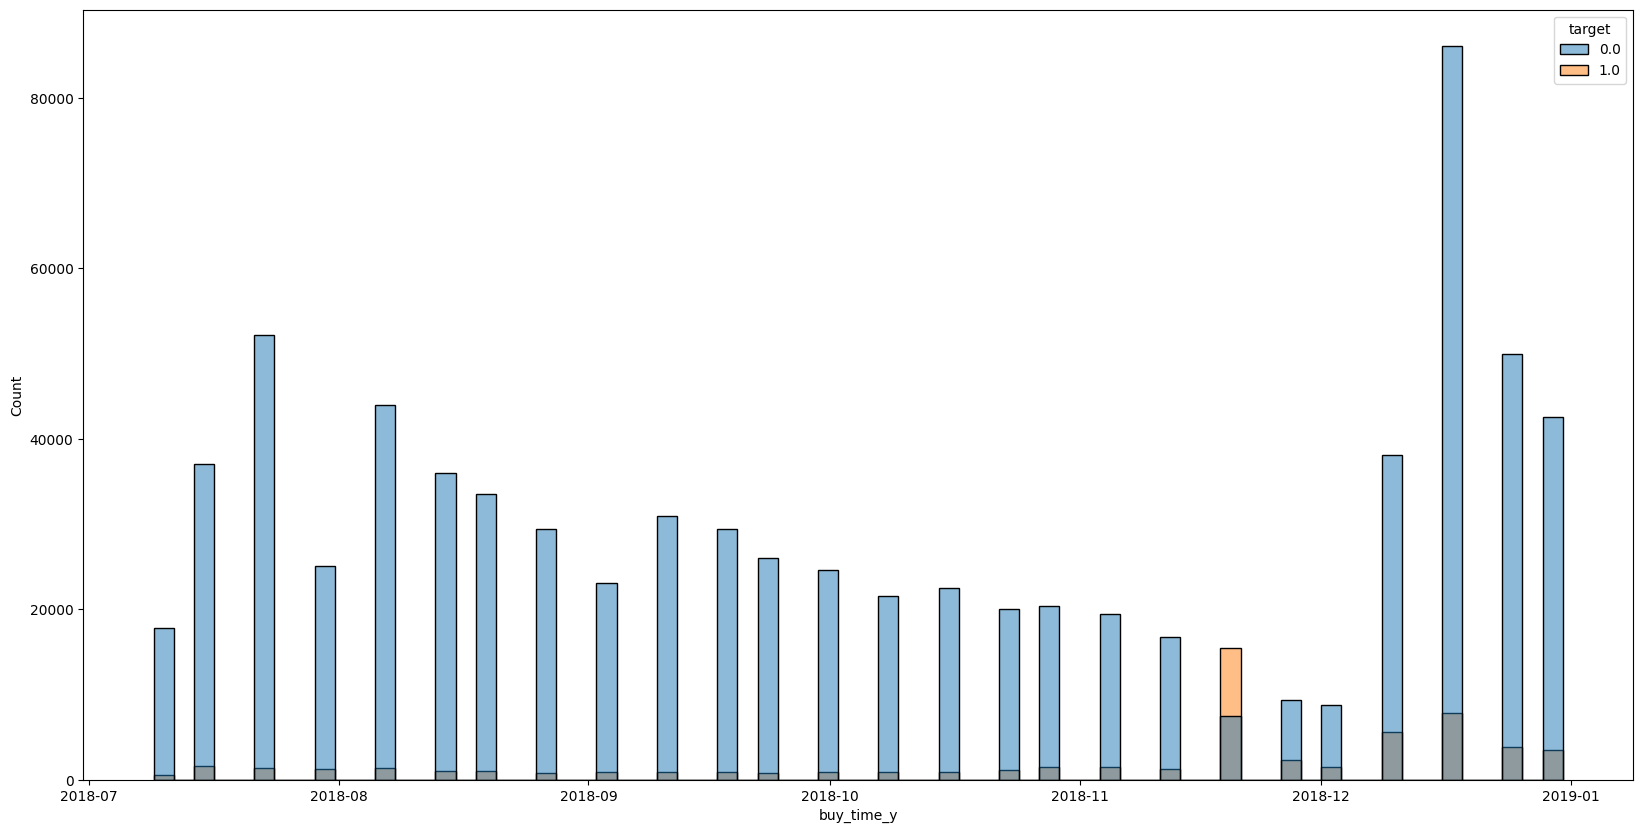

In [66]:
plt.figure(figsize=(20, 10))
sns.histplot(data=df, x='buy_time_y', hue='target')
plt.show()

Из графика наблюдается аномальное поведение в одном из дней ноября, а также увеличение покупок пользователей начиная с середины декабря месяца, что скорее всего связано с появлением новой услуги и повышенным предложением самого оператора.

Рассмотрим отдельно последние два месяца.

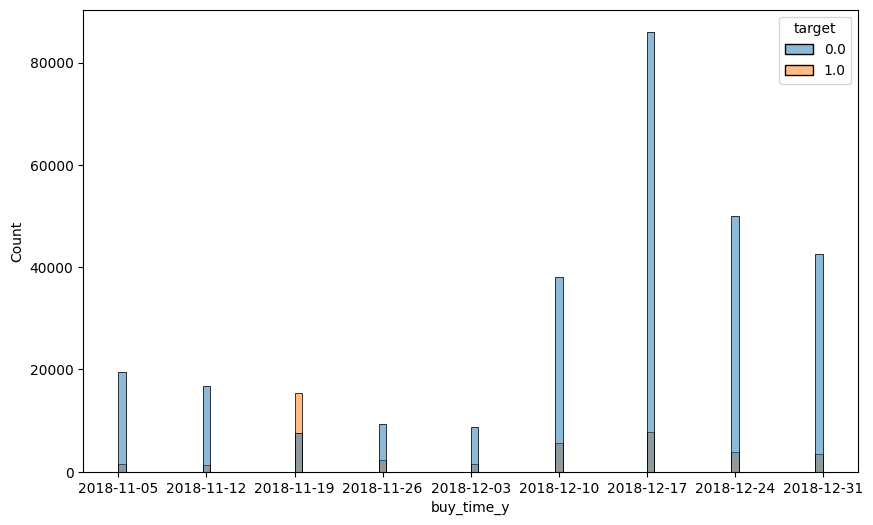

In [67]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df.loc[df.buy_month.isin([11, 12])], x='buy_time_y', hue='target')
plt.xticks(df.loc[df.buy_month.isin([11, 12]), 'buy_time_y'].unique())
plt.show()

Необходимо исключить из выборки все данные, полученные 19-11-2018, а за тестовую выборку возьмем декабрь.

In [68]:
df = df.loc[~((df['buy_month']==11) & (df['buy_day']==19))]

### 1.2 Разбиение тренировочных данных

In [69]:
# Разделим признаки и целевую переменную
data_prelim = df.copy()

data_prelim.set_index('id', inplace=True)

- Разбиваем данные по месяцам, чтобы найти закономерность именно на временном промежутке.
- Берем последний месяц - 12 за тестовую выборку, чтобы понять дальнейшие действия потребителей.

In [70]:
seed = 77

data_prelim_test = data_prelim.loc[data_prelim.buy_month.isin([12])]
data_prelim_train = data_prelim.loc[data_prelim.buy_month <= 11]


 # удаляем данные о реальной покупке, так как в тестовых данных будет присутствовать другой месяц


data_prelim.drop(['buy_month'], axis=1, inplace=True)
data_prelim_test.drop(['buy_month'], axis=1, inplace=True)
data_prelim_train.drop(['buy_month'], axis=1, inplace=True)
    
# data_prelim.drop(['buy_month', 'buy_day', 'buy_time_y', 'buy_time_x'], axis=1, inplace=True)
# data_prelim_test.drop(['buy_month', 'buy_day', 'buy_time_y', 'buy_time_x'], axis=1, inplace=True)
# data_prelim_train.drop(['buy_month', 'buy_day', 'buy_time_y', 'buy_time_x'], axis=1, inplace=True)

In [71]:
X = data_prelim.drop('target', axis=1)
y = data_prelim['target']

X_train, y_train = data_prelim_train.drop('target', axis=1), data_prelim_train['target']
X_test, y_test = data_prelim_test.drop('target', axis=1), data_prelim_test['target']

In [72]:
print("Train")
print(y_train.value_counts() / y_train.shape[0])
print()
print("Test")
print(y_test.value_counts() / y_test.shape[0])

Train
0.0    0.959787
1.0    0.040213
Name: target, dtype: float64

Test
0.0    0.910324
1.0    0.089676
Name: target, dtype: float64


### 1.3 Pipeline для baseline модели

In [73]:
# LogisticRegression
# возьмем параметр логистической регрессии 'balanced', для смещения диспбаланса в результатах

step_log_reg = ('log_reg', LogisticRegression(random_state=seed, n_jobs=-1, class_weight='balanced'))

In [74]:
bl_estimator = Pipeline([
    step_log_reg
])

### 1.4 Кросс-валидация

In [75]:
cv = KFold(n_splits=3, shuffle=True, random_state=seed)

def run_cv(estimator, cv, X, y, scoring='roc_auc', model_name=""):
    cv_res = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print("%s: %s = %0.2f (+/- %0.3f)" % (model_name,
                                         scoring,
                                         cv_res['test_score'].mean(),
                                         cv_res['test_score'].std() * 2))

In [77]:
%time run_cv(bl_estimator, cv, X_train, y_train, model_name='BaseLine')

BaseLine: roc_auc = 0.51 (+/- 0.001)
CPU times: total: 2.02 s
Wall time: 51.2 s


In [78]:
bl_estimator.fit(X_train, y_train)
bl_train_pred = bl_estimator.predict_proba(X_train)[:, 1]
bl_y_pred = bl_estimator.predict_proba(X_test)[:, 1]

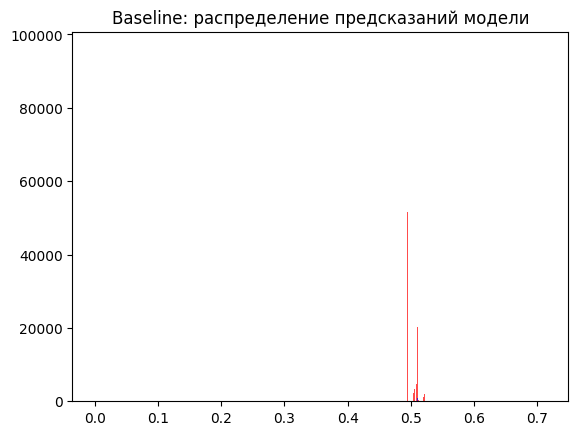

In [79]:
plt.title("Baseline: распределение предсказаний модели")
plt.hist(bl_y_pred[~y_test.astype(bool)], bins=1000, color='r', alpha=0.7);
plt.hist(bl_y_pred[y_test.astype(bool)], bins=1000, color='b', alpha=0.7);

In [80]:
print(classification_report(y_train, bl_train_pred > 0.5))
print(classification_report(y_test, bl_y_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.96      0.65      0.78    538592
         1.0       0.04      0.36      0.08     22566

    accuracy                           0.64    561158
   macro avg       0.50      0.51      0.43    561158
weighted avg       0.92      0.64      0.75    561158

              precision    recall  f1-score   support

         0.0       0.91      0.65      0.76    225378
         1.0       0.09      0.35      0.15     22202

    accuracy                           0.63    247580
   macro avg       0.50      0.50      0.45    247580
weighted avg       0.84      0.63      0.71    247580



Результат baseline очень плохой, так как для логистической регрессии необходимо было выполнить нормализацию признаков

### 2 Типы признаков

In [81]:
X_nunique = X.apply(lambda x: x.nunique())
X_nunique.shape

(257,)

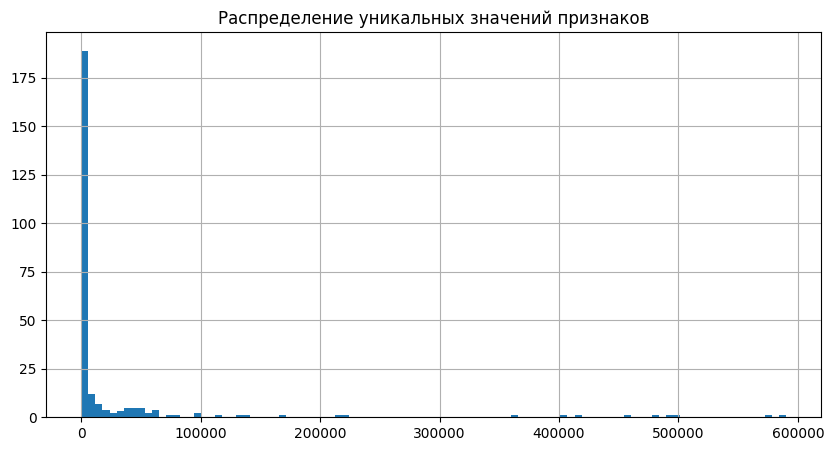

In [82]:
plt.title("Распределение уникальных значений признаков");
X_nunique.hist(bins=100, figsize=(10, 5));

In [83]:
f_all = set(X_nunique.index.tolist())
len(f_all)

257

#### константные признаки

In [84]:
# константные признаки
f_const = set(X_nunique[X_nunique == 1].index.tolist())
len(f_const)

5

#### вещественные признаки

In [85]:
f_numeric = (X.fillna(0).astype(int).sum() - X.fillna(0).sum()).abs()
f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
len(f_numeric)

247

In [86]:
f_other = f_all - (f_numeric | f_const) # остальные признаки
len(f_other)

5

#### бинарные признаки

In [87]:
f_binary = set(X.loc[:, f_other].columns[(
                      (X.loc[:, f_other].max() == 1) & \
                      (X.loc[:, f_other].min() == 0) & \
                      (X.loc[:, f_other].isnull().sum() == 0))])
len(f_binary)

0

#### категориальные признаки

In [88]:
f_other = f_other - f_binary
len(f_other)

5

In [89]:
f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 10].index.tolist())
f_numeric_extra = f_categorical
len(f_categorical)

3

In [90]:
f_other = f_other - f_categorical
len(f_other)

2

In [91]:
f_other

{'buy_day_feat', 'diff_time'}

In [92]:
f_numeric.update(f_other)

In [93]:
assert(X_nunique.shape[0] == len(f_const) + len(f_binary) + len(f_numeric) + len(f_categorical))

In [94]:
print('f_all:', X.shape[1])
print()
print('f_const:', len(f_const))
print('f_binary:', len(f_binary))
print('f_categorical:', len(f_categorical))
print('f_numeric:', len(f_numeric))

f_ok = list(f_binary | f_categorical | f_numeric)
f_binary, f_categorical, f_numeric = list(f_binary), list(f_categorical), list(f_numeric)

f_all: 257

f_const: 5
f_binary: 0
f_categorical: 3
f_numeric: 249


### 3. Pipeline

In [95]:
from sklearn.base import BaseEstimator, TransformerMixin

#### Column Selector

In [96]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        
        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            print(KeyError("DataFrame не содержит колонки %s" % cols_error))

In [97]:
# проверка работы
cs_pipe = Pipeline([
    ('cs', ColumnSelector(columns=['1', '2', '15', '252'])),
])

In [98]:
cs_pipe.transform(X_test).head(2)

,1,2,15,252
id,,,,
1138869,-36.559112,18.499214,-0.000725,1.0
4303403,515.950888,-47.150786,-0.000725,1.0


#### Prepare features

In [99]:
# выполняем стандартизацию для численных значений колонок
# для категориальных признаков выполняем OneHotEncoding

feat_prep_pipeline = make_pipeline(
    ColumnSelector(f_ok),
    FeatureUnion(transformer_list=[
        ('num_features', make_pipeline(
            ColumnSelector(f_numeric),
            StandardScaler()
        )),
        ('bin_features', make_pipeline(
            ColumnSelector(f_binary),
        )),
        ('cat_features', make_pipeline(
            ColumnSelector(f_categorical),
            OneHotEncoder(handle_unknown='ignore')
        ))
    ])
)

In [100]:
feat_prep_pipeline.steps

[('columnselector',
  ColumnSelector(columns=['buy_month_feat', '116', '36', '58', '241', '50', '78',
                          '246', '17', '174', 'diff_time', '196', '234', '163',
                          '164', '15', '112', '9', '5', '16', '145', '135', '201',
                          '187', '166', '172', '244', '40', '89', '185', ...])),
 ('featureunion',
  FeatureUnion(transformer_list=[('num_features',
                                  Pipeline(steps=[('columnselector',
                                                   ColumnSelector(columns=['116',
                                                                           '36',
                                                                           '58',
                                                                           '241',
                                                                           '50',
                                                                           '78',
                             

In [101]:
X_test.shape[1]

257

In [102]:
feat_prep_pipeline.fit(X_train)

n_features = feat_prep_pipeline.transform(X_test).shape[1]
n_features

267

#### Gridsearch для пайплайнов

In [103]:
lg_pipe = make_pipeline(
    feat_prep_pipeline,
    LogisticRegression(random_state=seed)
)

In [104]:
def run_grid_search(estimator, X, y, params_grid, cv, scoring='roc_auc', n_jobs=2):
    gsc = GridSearchCV(estimator, params_grid, scoring=scoring, cv=cv, n_jobs=n_jobs)
    
    gsc.fit(X, y)
    
    print("Best %s score: %.2f" % (scoring, gsc.best_score_))
    print()
    print("Best parameters set found on development set:")
    print()
    print(gsc.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    
    for i, params in enumerate(gsc.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (gsc.cv_results_['mean_test_score'][i], gsc.cv_results_['std_test_score'][i] * 2, params))

    print()
    
    return gsc

In [105]:
[k for k in lg_pipe.get_params().keys() if 'logisticregression' in k]

['logisticregression',
 'logisticregression__C',
 'logisticregression__class_weight',
 'logisticregression__dual',
 'logisticregression__fit_intercept',
 'logisticregression__intercept_scaling',
 'logisticregression__l1_ratio',
 'logisticregression__max_iter',
 'logisticregression__multi_class',
 'logisticregression__n_jobs',
 'logisticregression__penalty',
 'logisticregression__random_state',
 'logisticregression__solver',
 'logisticregression__tol',
 'logisticregression__verbose',
 'logisticregression__warm_start']

In [106]:
param_grid = {
    'logisticregression__penalty': ['l2'],
    'logisticregression__C': [5, 1, 0.1, 0.01],
    'logisticregression__class_weight': ['balanced']
}

In [107]:
KFold_cv = KFold(n_splits=3, shuffle=True, random_state=seed)

In [108]:
%%time
lg_gsc = run_grid_search(lg_pipe, X_train, y_train, param_grid, cv=KFold_cv)

Best roc_auc score: 0.85

Best parameters set found on development set:

{'logisticregression__C': 1, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2'}

Grid scores on development set:

0.849 (+/-0.005) for {'logisticregression__C': 5, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2'}
0.849 (+/-0.005) for {'logisticregression__C': 1, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2'}
0.849 (+/-0.005) for {'logisticregression__C': 0.1, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2'}
0.849 (+/-0.005) for {'logisticregression__C': 0.01, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2'}

CPU times: total: 1min 9s
Wall time: 7min 46s


Существенных изменений в логистической регрессии не вносит ни один гиперпараметр.

In [109]:
lg_gsc_best_prep = lg_gsc.best_estimator_

In [110]:
%%time
lg_gsc_best_prep.fit(X_train, y_train)

lg_gsc_best_prep_test_pred = lg_gsc_best_prep.predict_proba(X_test)[:,1]

lg_gsc_best_prep_train_pred = lg_gsc_best_prep.predict_proba(X_train)[:,1]

CPU times: total: 1min 29s
Wall time: 1min 30s


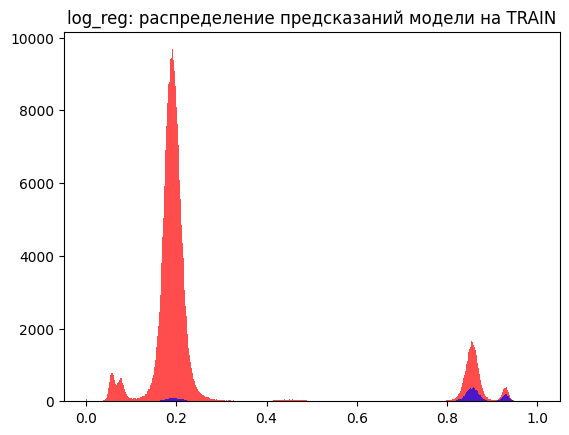

In [111]:
plt.title("log_reg: распределение предсказаний модели на TRAIN")
plt.hist(lg_gsc_best_prep_train_pred[~y_train.astype(bool)], bins=1000, color='r', alpha=0.7);
plt.hist(lg_gsc_best_prep_train_pred[y_train.astype(bool)], bins=1000, color='b', alpha=0.7);

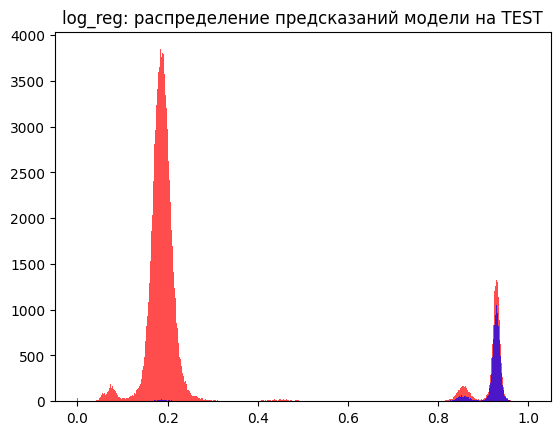

In [112]:
plt.title("log_reg: распределение предсказаний модели на TEST")
plt.hist(lg_gsc_best_prep_test_pred[~y_test.astype(bool)], bins=1000, color='r', alpha=0.7);
plt.hist(lg_gsc_best_prep_test_pred[y_test.astype(bool)], bins=1000, color='b', alpha=0.7);

In [120]:
threshold = 0.5
print('TRAIN')
print(classification_report(y_train, lg_gsc_best_prep_train_pred > threshold))
print('*' * 100)
print('TEST')
print(classification_report(y_test, lg_gsc_best_prep_test_pred > threshold))

TRAIN
              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93    538592
         1.0       0.22      0.79      0.34     22566

    accuracy                           0.88    561158
   macro avg       0.60      0.84      0.64    561158
weighted avg       0.96      0.88      0.91    561158

****************************************************************************************************
TEST
              precision    recall  f1-score   support

         0.0       1.00      0.86      0.92    225378
         1.0       0.40      0.97      0.57     22202

    accuracy                           0.87    247580
   macro avg       0.70      0.91      0.74    247580
weighted avg       0.94      0.87      0.89    247580



### Отбор признаков

In [121]:
from sklearn.feature_selection import SelectFromModel

In [122]:
feat_select = make_pipeline(
    feat_prep_pipeline,
    SelectFromModel(LogisticRegression(random_state=seed), threshold=10e-4)
)

In [123]:
feat_prep_pipeline.fit(X_train, y_train)
feat_prep_pipeline.transform(X_test).shape

(247580, 267)

In [124]:
feat_select.fit(X_train, y_train)
feat_select.transform(X_test).shape

(247580, 253)

In [125]:
lg_feat_select_pipe = make_pipeline(
    feat_prep_pipeline,
    SelectFromModel(LogisticRegression(random_state=seed, class_weight='balanced', penalty='l2'), threshold=1e-4),
    LogisticRegression(random_state=seed, class_weight='balanced', penalty='l2')
)

In [126]:
[k for k in lg_feat_select_pipe.get_params() if 'select' in k]

['selectfrommodel',
 'pipeline__columnselector',
 'pipeline__columnselector__columns',
 'pipeline__featureunion__num_features__columnselector',
 'pipeline__featureunion__num_features__columnselector__columns',
 'pipeline__featureunion__bin_features__columnselector',
 'pipeline__featureunion__bin_features__columnselector__columns',
 'pipeline__featureunion__cat_features__columnselector',
 'pipeline__featureunion__cat_features__columnselector__columns',
 'selectfrommodel__estimator__C',
 'selectfrommodel__estimator__class_weight',
 'selectfrommodel__estimator__dual',
 'selectfrommodel__estimator__fit_intercept',
 'selectfrommodel__estimator__intercept_scaling',
 'selectfrommodel__estimator__l1_ratio',
 'selectfrommodel__estimator__max_iter',
 'selectfrommodel__estimator__multi_class',
 'selectfrommodel__estimator__n_jobs',
 'selectfrommodel__estimator__penalty',
 'selectfrommodel__estimator__random_state',
 'selectfrommodel__estimator__solver',
 'selectfrommodel__estimator__tol',
 'selec

In [139]:
%%time
param_grid = [
    {
        "selectfrommodel__max_features": [None, 10, 50, 100, 150],
        "selectfrommodel__threshold": [-np.inf]
    },
    {
        "selectfrommodel__threshold": [10e-4]
    }
]

lg_feat_select_gsc = run_grid_search(lg_feat_select_pipe, X_train, y_train, param_grid, KFold_cv)

Best roc_auc score: 0.85

Best parameters set found on development set:

{'selectfrommodel__max_features': 100, 'selectfrommodel__threshold': -inf}

Grid scores on development set:

0.849 (+/-0.005) for {'selectfrommodel__max_features': None, 'selectfrommodel__threshold': -inf}
0.848 (+/-0.007) for {'selectfrommodel__max_features': 10, 'selectfrommodel__threshold': -inf}
0.849 (+/-0.008) for {'selectfrommodel__max_features': 50, 'selectfrommodel__threshold': -inf}
0.850 (+/-0.006) for {'selectfrommodel__max_features': 100, 'selectfrommodel__threshold': -inf}
0.850 (+/-0.006) for {'selectfrommodel__max_features': 150, 'selectfrommodel__threshold': -inf}
0.849 (+/-0.005) for {'selectfrommodel__threshold': 0.001}

CPU times: total: 1min 30s
Wall time: 15min 34s


### Лучшие параметры LogReg

In [140]:
lg_best = lg_feat_select_gsc.best_estimator_

In [141]:
%%time
lg_best.fit(X_train, y_train)

lg_pipe_best_train_pred = lg_best.predict_proba(X_train)[:,1]

lg_best_test_pred = lg_best.predict_proba(X_test)[:,1]

CPU times: total: 1min 49s
Wall time: 1min 51s


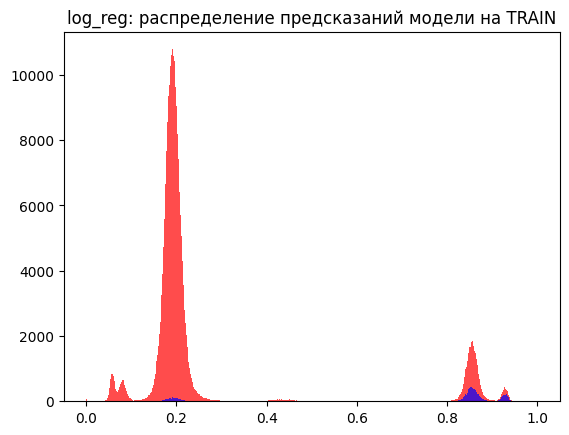

In [142]:
plt.title("log_reg: распределение предсказаний модели на TRAIN")
plt.hist(lg_pipe_best_train_pred[~y_train.astype(bool)], bins=1000, color='r', alpha=0.7);
plt.hist(lg_pipe_best_train_pred[y_train.astype(bool)], bins=1000, color='b', alpha=0.7);

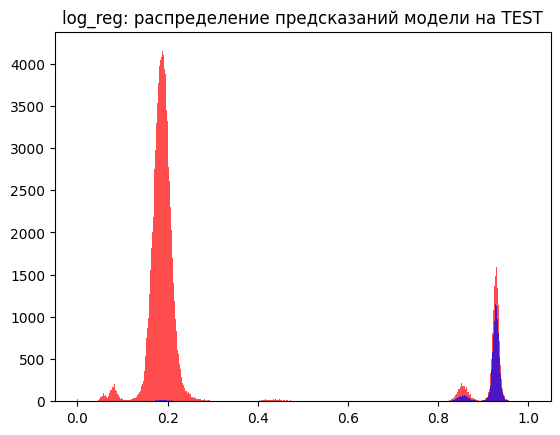

In [143]:
plt.title("log_reg: распределение предсказаний модели на TEST")
plt.hist(lg_best_test_pred[~y_test.astype(bool)], bins=1000, color='r', alpha=0.7);
plt.hist(lg_best_test_pred[y_test.astype(bool)], bins=1000, color='b', alpha=0.7);

In [144]:
threshold = 0.5
print('TRAIN')
print(classification_report(y_train, lg_pipe_best_train_pred > threshold))
print('*' * 100)
print('TEST')
print(classification_report(y_test, lg_best_test_pred > threshold))

TRAIN
              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93    538592
         1.0       0.22      0.79      0.34     22566

    accuracy                           0.88    561158
   macro avg       0.60      0.84      0.64    561158
weighted avg       0.96      0.88      0.91    561158

****************************************************************************************************
TEST
              precision    recall  f1-score   support

         0.0       1.00      0.86      0.92    225378
         1.0       0.40      0.97      0.57     22202

    accuracy                           0.87    247580
   macro avg       0.70      0.91      0.75    247580
weighted avg       0.94      0.87      0.89    247580



### GradientBoostingClassifier

In [145]:
grad_fs_pipe = make_pipeline(
    feat_prep_pipeline,
    SelectFromModel(LogisticRegression(random_state=seed, class_weight='balanced'), threshold=-np.inf),
    GradientBoostingClassifier(random_state=seed)
)

In [146]:
[k for k in grad_fs_pipe.get_params() if 'gradient' in k]

['gradientboostingclassifier',
 'gradientboostingclassifier__ccp_alpha',
 'gradientboostingclassifier__criterion',
 'gradientboostingclassifier__init',
 'gradientboostingclassifier__learning_rate',
 'gradientboostingclassifier__loss',
 'gradientboostingclassifier__max_depth',
 'gradientboostingclassifier__max_features',
 'gradientboostingclassifier__max_leaf_nodes',
 'gradientboostingclassifier__min_impurity_decrease',
 'gradientboostingclassifier__min_samples_leaf',
 'gradientboostingclassifier__min_samples_split',
 'gradientboostingclassifier__min_weight_fraction_leaf',
 'gradientboostingclassifier__n_estimators',
 'gradientboostingclassifier__n_iter_no_change',
 'gradientboostingclassifier__random_state',
 'gradientboostingclassifier__subsample',
 'gradientboostingclassifier__tol',
 'gradientboostingclassifier__validation_fraction',
 'gradientboostingclassifier__verbose',
 'gradientboostingclassifier__warm_start']

In [3]:
params = {
    'selectfrommodel__max_features': [100],
    'gradientboostingclassifier__max_features': ['sqrt', 'log2', None],
#     'gradientboostingclassifier__loss': ['exponential', 'log_loss'],
#     'gradientboostingclassifier__ccp_alpha': [],
#     'gradientboostingclassifier__criterion': [],
#     'gradientboostingclassifier__init': [],
#     'gradientboostingclassifier__learning_rate': [],
#     'gradientboostingclassifier__max_depth': [1, 3, 5],
#     'gradientboostingclassifier__max_leaf_nodes': [],
#     'gradientboostingclassifier__min_impurity_decrease': [],
#     'gradientboostingclassifier__min_samples_leaf': [],
#     'gradientboostingclassifier__min_samples_split': [],
#     'gradientboostingclassifier__min_weight_fraction_leaf': [],
#     'gradientboostingclassifier__n_estimators': [],
#     'gradientboostingclassifier__n_iter_no_change': [],
#     'gradientboostingclassifier__random_state': [],
#     'gradientboostingclassifier__subsample': [],
#     'gradientboostingclassifier__tol': [],
#     'gradientboostingclassifier__validation_fraction': [],
#     'gradientboostingclassifier__verbose': [],
#     'gradientboostingclassifier__warm_start': []
}

In [4]:
%%time
grad_fs_gsc = run_grid_search(grad_fs_pipe, X_train, y_train, params, KFold_cv, n_jobs=-1)

NameError: name 'run_grid_search' is not defined

In [ ]:
grad_fs_best = grad_fs_gsc.best_estimator_

In [ ]:
%%time
grad_fs_best.fit(X_train, y_train)

grad_fs_train_pred = grad_fs_best.predict_proba(X_train)[:,1]
grad_fs_test_pred = grad_fs_best.predict_proba(X_test)[:,1]

In [ ]:
plt.title("GradBoosting: распределение предсказаний модели на Train")
plt.hist(grad_fs_train_pred[~y_train.astype(bool)], bins=1000, color='r', alpha=0.7);
plt.hist(grad_fs_train_pred[y_train.astype(bool)], bins=1000, color='b', alpha=0.7);

In [ ]:
plt.title("GradBoosting: распределение предсказаний модели на Test")
plt.hist(grad_fs_test_pred[~y_test.astype(bool)], bins=1000, color='r', alpha=0.7);
plt.hist(grad_fs_test_pred[y_test.astype(bool)], bins=1000, color='b', alpha=0.7);

In [ ]:
print('TRAIN')
print(classification_report(y_train, grad_fs_train_pred > 0.2))
print('*' * 100)
print('TEST')
print(classification_report(y_test, grad_fs_test_pred > 0.2))

### LightGBM Classifier

In [ ]:
lgbm_fs_pipe = make_pipeline(
    feat_prep_pipeline,
    SelectFromModel(LogisticRegression(random_state=seed, class_weight='balanced'), threshold=-np.inf),
    LGBMClassifier(random_state=seed, objective='binary')
)

In [ ]:
[k for k in lgbm_fs_pipe.get_params() if 'lgbm' in k]

In [ ]:
params = [
    {
        'selectfrommodel__max_features': [50]
    },
    {
        'selectfrommodel_max_features': [None],
#     'lgbmclassifier__boosting_type': ['gbdt', 'dart', 'goss'],
#     'lgbmclassifier__max_depth': [2, 4, 6, 8],
#     'lgbmclassifier__reg_alpha': [3, 1, 0.5, 0.1, 0.01],
#     'lgbmclassifier__reg_lambda': [3, 1, 0.5, 0.1, 0.01],
#     'lgbmclassifier__learning_rate': [1, 0.5, 0.3, 0.1, 0.05, 0.01],
#     'lgbmclassifier__n_estimators': [10, 50, 100, 200, 300, 500],
#     'lgbmclassifier__class_weight': ['balanced'],
#     'lgbmclassifier__num_leaves': [10],
    }
]

In [ ]:
%%time
lgbm_feat_select_gsc = run_grid_search(lgbm_fs_pipe, X_train, y_train, params, KFold_cv)

In [ ]:
lgbm_pipe_best = lgbm_feat_select_gsc.best_estimator_

In [ ]:
%%time
lgbm_pipe_best.fit(X_train, y_train)

lgbm_pipe_best_pred = lgbm_pipe_best.predict_proba(X_test)[:,1]

In [ ]:
lgbm_pipe_train_pred = lgbm_pipe_best.predict_proba(X_train)[:,1]

In [ ]:
plt.title("LightGBM: распределение предсказаний модели на Train")
plt.hist(lgbm_pipe_train_pred[~y_train.astype(bool)], bins=100, color='r', alpha=0.7);
plt.hist(lgbm_pipe_train_pred[y_train.astype(bool)], bins=100, color='b', alpha=0.7);

In [ ]:
plt.title("LightGBM: распределение предсказаний модели на Test")
plt.hist(lgbm_pipe_best_pred[~y_test.astype(bool)], bins=100, color='r', alpha=0.7);
plt.hist(lgbm_pipe_best_pred[y_test.astype(bool)], bins=100, color='b', alpha=0.7);

In [ ]:
print('TRAIN')
print(classification_report(y_train, lgbm_pipe_train_pred > 0.8))
print('*' * 100)
print('TEST')
print(classification_report(y_test, lgbm_pipe_best_pred > 0.8))

### Сравнение моделей

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(24)
f.set_figwidth(12)

ax1 = plt.subplot(211)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')


ax2 = plt.subplot(212)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')

fpr, tpr, roc_thresholds = roc_curve(y_test, bl_y_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, bl_y_pred)
ax1.plot(fpr, tpr, label='Baseline', color='b')
ax2.plot(recall, precision, label='Baseline', color='b')
print("Baseline: AUC_PR = %.3f" % auc(recall, precision))
print("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))


fpr, tpr, roc_thresholds = roc_curve(y_test, lg_fs_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, lg_fs_pred)
ax1.plot(fpr, tpr, label="lg_fs_pred", color='g')
ax2.plot(recall, precision, label="lg_fs_pred", color='g')
print("lg_fs_pred: AUC_PR = %.3f" % auc(recall, precision))
print("lg_fs_pred: AUC_ROC = %.3f" % auc(fpr, tpr))


fpr, tpr, roc_thresholds = roc_curve(y_test, gb_fs_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, gb_fs_pred)
ax1.plot(fpr, tpr, label="gb_fs_pred", color='purple')
ax2.plot(recall, precision, label="gb_fs_pred", color='purple')
print("gb_fs_pred: AUC_PR = %.3f" % auc(recall, precision))
print("gb_fs_pred: AUC_ROC = %.3f" % auc(fpr, tpr))
ax1.legend(loc="lower right")
ax2.legend(loc="lower right");